In [1]:
# imports
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization, LSTM
from tensorflow.keras.regularizers import l2
from sklearn.utils import shuffle
from scipy.interpolate import CubicSpline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from tqdm import tqdm
from google.colab import drive
# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
set_seed(42)

In [2]:
# Mount Google Drive
drive.mount('/content/drive')
# Change to the ICBHI2024 directory on my Google Drive
os.chdir('/content/drive/MyDrive/ICBHI2024')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Augmentation functions
def add_noise(data, noise_factor=0.5):
    noise = np.random.randn(*data.shape) * noise_factor
    return data + noise

def scale_data(data, scale_factor=1.2):
    return data * scale_factor

def time_warp(data, sigma=0.2):
    if len(data.shape) != 2:
        raise ValueError("Data shape is not compatible for time warping.")
    orig_steps = np.arange(data.shape[1])
    random_warp = np.random.normal(loc=1.0, scale=sigma, size=data.shape[1])
    warp_steps = np.cumsum(random_warp) / np.sum(random_warp) * (data.shape[1] - 1)
    warped_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        cs = CubicSpline(orig_steps, data[i, :])
        warped_data[i, :] = cs(warp_steps)
    return warped_data

def jitter(data, sigma=0.05):
    return data + np.random.normal(loc=0.0, scale=sigma, size=data.shape)

# Function to clean data
def clean_data(data):
    if not np.all(np.isfinite(data)):
        if data.ndim == 1:
            mean_val = np.nanmean(data)
            data = np.where(np.isfinite(data), data, mean_val)
        elif data.ndim == 2:
            mean_vals = np.nanmean(data, axis=1, keepdims=True)
            data = np.where(np.isfinite(data), data, mean_vals)
    return data

# Function to augment data
def augment_data(data, labels):
    augmented_data = []
    augmented_labels = []
    for sample, label in zip(data, labels):
        sample = clean_data(sample)  # Clean data before augmentation

        augmented_data.append(sample)
        augmented_labels.append(label)

        augmented_data.append(add_noise(sample))
        augmented_labels.append(label)

        augmented_data.append(scale_data(sample))
        augmented_labels.append(label)

        augmented_data.append(time_warp(sample[np.newaxis, ...]).squeeze(0))
        augmented_labels.append(label)

        augmented_data.append(jitter(sample))
        augmented_labels.append(label)

    return np.array(augmented_data), np.array(augmented_labels)

# Function to load data from npz files
def load_npz_data(fpath):
    all_data = np.load(fpath)
    return all_data['data']

# Function to load participant data
def load_participants_data(data_dir, augment_data_flag=False, labels_present=True):
    subjects = sorted([s for s in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, s))])
    all_ppg_data = []
    all_labels = []
    subject_names = []

    print(f"Loading data from {data_dir}...")
    for subject in subjects:
        if subject.startswith('.'):
            continue  # skip hidden files like .DS_Store

        subject_path = os.path.join(data_dir, subject)
        ppg_data_path = os.path.join(subject_path, 'PPG_data.npz')

        if os.path.exists(ppg_data_path):
            ppg_data = load_npz_data(ppg_data_path)
            print(f"Subject {subject} PPG data shape: {ppg_data.shape}")
            ppg_data = ppg_data[:, 2000:8000]
            all_ppg_data.append(ppg_data)
        else:
            print(f"Missing data for {subject}")

        if labels_present:
            labels_path = os.path.join(subject_path, 'labels.npz')
            if os.path.exists(labels_path):
                labels = load_npz_data(labels_path)[:, 1].astype(int)  # Only take the level label
                print(f"Subject {subject} labels shape: {labels.shape}")
                all_labels.append(labels)
            else:
                print(f"Missing labels for {subject}")

        # Track the subject names
        subject_names.append(subject)

    # Combine all data and labels from all subjects
    all_ppg_data = np.concatenate(all_ppg_data, axis=0)
    print(f"All PPG data shape after concatenation: {all_ppg_data.shape}")
    all_labels = np.concatenate(all_labels, axis=0) if labels_present and all_labels else None
    if all_labels is not None:
        print(f"All labels shape after concatenation: {all_labels.shape}")

    if augment_data_flag and all_labels is not None:
        all_ppg_data, all_labels = augment_data(all_ppg_data, all_labels)
        print(f"Augmented PPG data shape: {all_ppg_data.shape}")
        print(f"Augmented labels shape: {all_labels.shape}")

    if labels_present and all_labels is not None:
        return {'ppg_data': all_ppg_data, 'labels': all_labels, 'subject_names': subject_names}
    else:
        return {'ppg_data': all_ppg_data, 'subject_names': subject_names}

# Load data
train_data_dir = 'data/Train'
test_data_dir = 'data/Test'

train_data = load_participants_data(train_data_dir, augment_data_flag=True, labels_present=True)
test_data = load_participants_data(test_data_dir, augment_data_flag=False, labels_present=False)

print(f"Train data keys: {train_data.keys()}")
print(f"Test data keys: {test_data.keys()}")
print(f"Train PPG data shape: {train_data['ppg_data'].shape}")
print(f"Train labels shape: {train_data['labels'].shape}")
print(f"Test PPG data shape: {test_data['ppg_data'].shape}")

Loading data from data/Train...
Subject P01 PPG data shape: (30, 10000)
Subject P01 labels shape: (30,)
Subject P02 PPG data shape: (30, 10000)
Subject P02 labels shape: (30,)
Subject P03 PPG data shape: (30, 10000)
Subject P03 labels shape: (30,)
Subject P04 PPG data shape: (30, 10000)
Subject P04 labels shape: (30,)
Subject P05 PPG data shape: (30, 10000)
Subject P05 labels shape: (30,)
Subject P06 PPG data shape: (30, 10000)
Subject P06 labels shape: (30,)
Subject P07 PPG data shape: (30, 10000)
Subject P07 labels shape: (30,)
Subject P08 PPG data shape: (30, 10000)
Subject P08 labels shape: (30,)
Subject P09 PPG data shape: (30, 10000)
Subject P09 labels shape: (30,)
Subject P10 PPG data shape: (30, 10000)
Subject P10 labels shape: (30,)
Subject P11 PPG data shape: (30, 10000)
Subject P11 labels shape: (30,)
Subject P12 PPG data shape: (30, 10000)
Subject P12 labels shape: (30,)
Subject P13 PPG data shape: (30, 10000)
Subject P13 labels shape: (30,)
Subject P14 PPG data shape: (30,

Initial shapes - X_train: (2400, 6000) y_train: (2400,) X_test: (120, 6000)
Shapes after scaling - X_train: (2400, 6000) X_test: (120, 6000)
Shapes after flattening - X_train_flat: (2400, 6000) X_test_flat: (120, 6000)
Shapes after imputation - X_train_flat: (2400, 6000) X_test_flat: (120, 6000)
Shapes after PCA - X_train_pca: (2400, 100) X_test_pca: (120, 100)
Shapes after reshaping for Conv1D - X_train_pca: (2400, 100, 1) X_test_pca: (120, 100, 1)
Shapes after train-validation split - X_train_pca: (1800, 100, 1) X_val_pca: (600, 100, 1)
Shapes after train-validation split - y_train: (1800,) y_val: (600,)
Sample of scaled labels - y_train_scaled: [ 0.5   1.    0.   -0.5   0.    0.5   0.25  0.    0.   -0.25] y_val_scaled: [-0.25 -0.75  1.    0.    0.    1.    0.75 -1.    0.5   0.  ]
Model architecture:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10

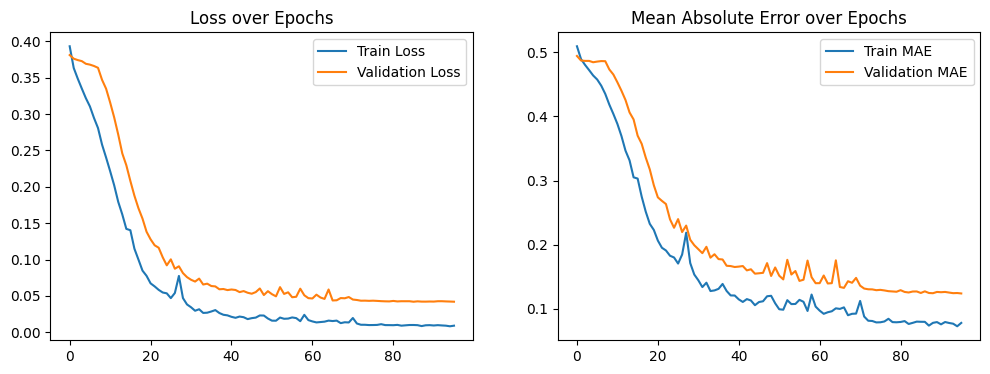

4/4 [==============================] - 0s 3ms/step
First 120 predictions:
[[-1.2116913 ]
 [-0.69292533]
 [-0.44598055]
 [-0.28539732]
 [ 1.3040936 ]
 [ 1.5152875 ]
 [ 0.5710256 ]
 [-0.455527  ]
 [-1.7007169 ]
 [-0.2785706 ]
 [-0.8532931 ]
 [-1.4478594 ]
 [-1.6791546 ]
 [ 1.103367  ]
 [ 1.0752807 ]
 [ 1.4852269 ]
 [ 0.28372848]
 [ 0.70943713]
 [ 0.32975653]
 [ 1.3107494 ]
 [ 1.5427474 ]
 [-0.36518842]
 [ 1.5800437 ]
 [ 1.6420326 ]
 [-1.5476893 ]
 [-0.616518  ]
 [ 0.37881798]
 [-2.2450318 ]
 [-0.3440909 ]
 [-0.7244493 ]
 [-2.6633258 ]
 [ 0.80086124]
 [ 0.09772927]
 [ 2.473391  ]
 [-0.96867484]
 [-0.16581419]
 [ 0.3453514 ]
 [ 2.7577145 ]
 [-2.883296  ]
 [ 0.33379355]
 [ 0.41786766]
 [-0.21096683]
 [ 0.08795752]
 [ 1.6835599 ]
 [ 3.1676097 ]
 [-1.6548567 ]
 [-0.5282098 ]
 [-0.0972464 ]
 [ 2.386757  ]
 [ 0.24046285]
 [ 0.52056134]
 [ 0.61602616]
 [ 0.557994  ]
 [-0.61279064]
 [ 1.6067783 ]
 [-1.1865329 ]
 [-0.4104274 ]
 [-1.1348082 ]
 [-3.6238697 ]
 [-1.4815897 ]
 [-0.9853559 ]
 [ 2.418971

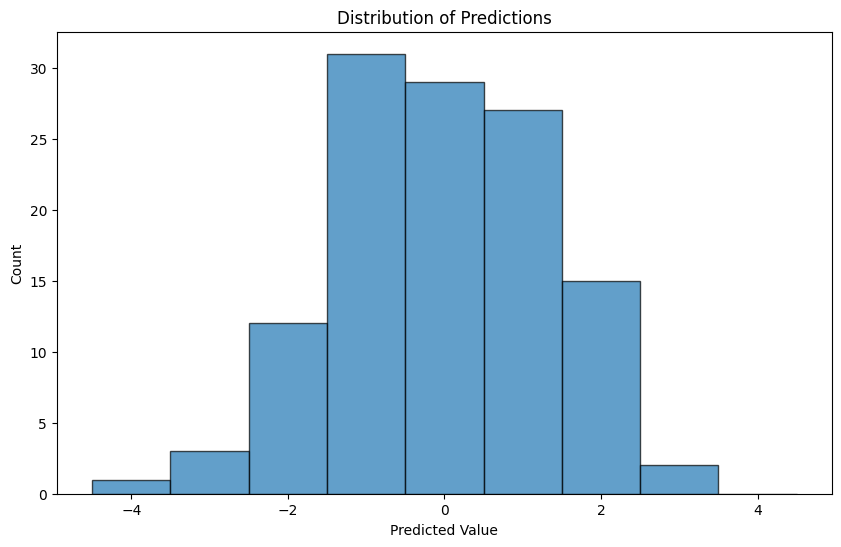

In [4]:
# Check data loading and initial shapes
print("Initial shapes - X_train:", train_data['ppg_data'].shape, "y_train:", train_data['labels'].shape, "X_test:", test_data['ppg_data'].shape)

# Shuffle data
X_train, y_train = shuffle(train_data['ppg_data'], train_data['labels'], random_state=42)
X_test = test_data['ppg_data']

# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
print("Shapes after scaling - X_train:", X_train.shape, "X_test:", X_test.shape)

# Flatten data for PCA
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
print("Shapes after flattening - X_train_flat:", X_train_flat.shape, "X_test_flat:", X_test_flat.shape)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_flat = imputer.fit_transform(X_train_flat)
X_test_flat = imputer.transform(X_test_flat)
print("Shapes after imputation - X_train_flat:", X_train_flat.shape, "X_test_flat:", X_test_flat.shape)

# Apply PCA
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)
print("Shapes after PCA - X_train_pca:", X_train_pca.shape, "X_test_pca:", X_test_pca.shape)

# Reshape data for input into Conv1D (add channel dimension)
X_train_pca = X_train_pca.reshape((X_train_pca.shape[0], X_train_pca.shape[1], 1))
X_test_pca = X_test_pca.reshape((X_test_pca.shape[0], X_test_pca.shape[1], 1))
print("Shapes after reshaping for Conv1D - X_train_pca:", X_train_pca.shape, "X_test_pca:", X_test_pca.shape)

# Split the training data for validation
X_train_pca, X_val_pca, y_train, y_val = train_test_split(X_train_pca, y_train, test_size=0.25, random_state=42)
print("Shapes after train-validation split - X_train_pca:", X_train_pca.shape, "X_val_pca:", X_val_pca.shape)
print("Shapes after train-validation split - y_train:", y_train.shape, "y_val:", y_val.shape)

# Normalize labels to the range [-1, 1]
label_scaler = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = label_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = label_scaler.transform(y_val.reshape(-1, 1)).flatten()
print("Sample of scaled labels - y_train_scaled:", y_train_scaled[:10], "y_val_scaled:", y_val_scaled[:10])

# Define the CNN-LSTM model for regression
def create_cnn_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    # x = Dropout(0.1)(x)
    x = Conv1D(128, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    # x = Dropout(0.1)(x)
    x = LSTM(64, return_sequences=False)(x)
    # x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    # x = Dropout(0.1)(x)
    outputs = Dense(1, activation='tanh')(x)
    model = Model(inputs, outputs)
    return model

# Create and compile the model
input_shape = (X_train_pca.shape[1], 1)
model = create_cnn_lstm_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

print("Model architecture:")
model.summary()

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model with early stopping and learning rate reduction
history = model.fit(X_train_pca, y_train_scaled,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_val_pca, y_val_scaled),
                    callbacks=[early_stopping, reduce_lr])

# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.legend()
plt.title('Mean Absolute Error over Epochs')

plt.show()

# Making predictions on the test data
predictions_scaled = model.predict(X_test_pca)

# Clip the predictions to the range of [-1, 1] before inverse scaling
predictions_scaled = np.clip(predictions_scaled, -1, 1)

# Transform predictions back to original range
predictions = label_scaler.inverse_transform(predictions_scaled)

# Clip the predictions to the range of [-4, 4]
predictions = np.clip(predictions, -4, 4)

# Display the first few predictions
print("First 120 predictions:")
print(predictions[:120])

# Plot the distribution of predictions
plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=np.arange(-4.5, 5.5, 1), alpha=0.7, edgecolor='black')
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Value')
plt.ylabel('Count')
plt.show()

In [5]:
# Print the final training and validation accuracy and loss
train_mae = history.history['mean_absolute_error'][-1]
val_mae = history.history['val_mean_absolute_error'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f"Final Training MAE: {train_mae}")
print(f"Final Validation MAE: {val_mae}")
print(f"Final Training Loss: {train_loss}")
print(f"Final Validation Loss: {val_loss}")


Final Training MAE: 0.07814833521842957
Final Validation MAE: 0.12403862178325653
Final Training Loss: 0.009125991724431515
Final Validation Loss: 0.04208054021000862


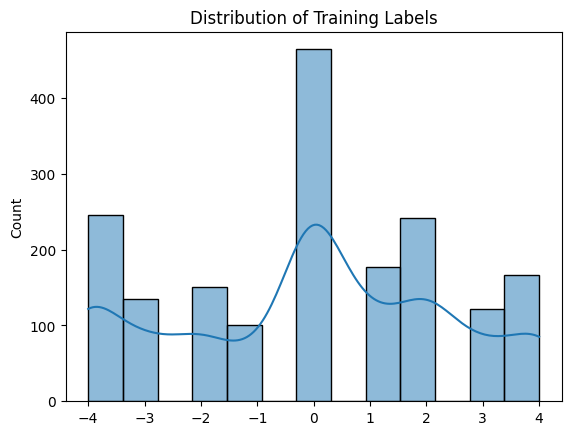

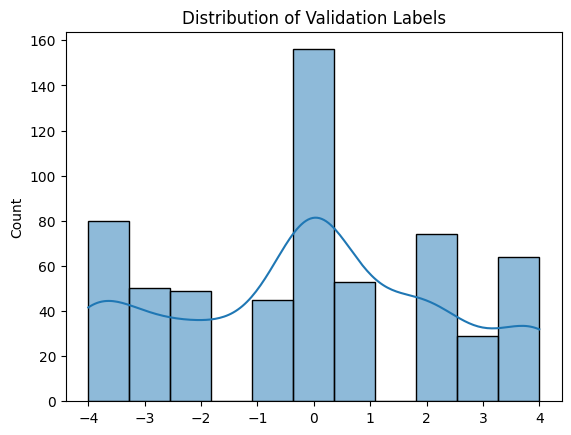

In [6]:
import seaborn as sns

# Plot the distribution of the labels
sns.histplot(y_train, kde=True)
plt.title('Distribution of Training Labels')
plt.show()

sns.histplot(y_val, kde=True)
plt.title('Distribution of Validation Labels')
plt.show()
